# Load and Perturbe Image

In [1]:
from __future__ import print_function, division
import cv2
import torch
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import gin
results_dir = 'results/'
example_name = "toyexample_6"

import os
import sys
gin.enter_interactive_mode()
module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
visualization_path = os.path.abspath(os.path.join('../../visualization'))
if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
if visualization_path not in sys.path:
    sys.path.append(visualization_path)
gin.enter_interactive_mode()

In [2]:
%load_ext autoreload
%autoreload 2



from FeaturePnP.model import sparseFeaturePnP
from FeaturePnP.helpers.utils import sobel_filter

In [3]:
toy_pickle_path = "data/%s_data.p" % example_name
toy_image_path = "data/%s.png" % example_name

In [4]:
data = pickle.load(open(toy_pickle_path, 'rb'))
img = cv2.imread(toy_image_path)

In [5]:
#Create a 10° rotated (around z-axis) calibrated projection matrix (relative to identity)
T_perturbed = np.array([[math.cos(4*math.pi/180), -math.sin(4*math.pi/180), 0, 0],
             [math.sin(4*math.pi/180), math.cos(4*math.pi/180), 0, 0],
             [0, 0, 1, 0]])

In [6]:
data['coords'] = np.around(data['2d_points']).astype(int) - 1

In [7]:
data['K']

array([[ 50.,   0., 512.],
       [  0.,  50., 512.],
       [  0.,   0.,   1.]])

In [8]:
# Camera matrix
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]

In [9]:
# Round double coords to ints -> to use as index in matrix
coords_2d = np.around(projected_2d)
coords_2d = coords_2d.astype(int) - 1

In [10]:
# Draw perturbed points into original image
img = img.astype('uint8')
for i, p in enumerate(coords_2d):
    print(i, p)
    cv2.circle(img, tuple(p), 4, (128, 128, 0), -1)

0 [492 828]
1 [742 489]
2 [294 189]
3 [893 680]
4 [152 822]
5 [557 329]
6 [375  94]
7 [434 863]
8 [ 19 776]
9 [736 292]
10 [852 462]
11 [425 676]
12 [182 319]
13 [165 295]


True

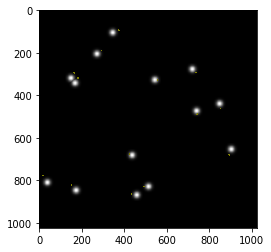

In [11]:
# Show image with perturbed points + Write
plt.imshow(img)
cv2.imwrite(results_dir + example_name + '_perturbed_points.png', img)

# Feature BA

In [12]:

from model import optimizer_step, indexing_

from helpers.utils import (from_homogeneous, to_homogeneous,
                batched_eye_like, skew_symmetric, so3exp_map)

from helpers.utils import squared_loss, scaled_loss

from torch.nn.functional import interpolate

In [13]:
# Reload image as doubles
data = pickle.load(open(toy_pickle_path, 'rb'))
img = cv2.imread(toy_image_path,0)
img = img.astype('double')

In [14]:
# Create image tensor
img_torch = torch.from_numpy(img)[None,...]

# Convolve Sobel Filter to extract x and y gradient: 1xHxW
grad_x, grad_y = sobel_filter(img_torch)

In [15]:
%%capture
# Exemplary, Show perturbed points on the y-gradient of the image. Resized to 128x128
"""
grad_y_img = grad_y.numpy().reshape(img.shape).astype('uint8')
for i, p in enumerate(coords_2d):
    print(i, p)
    cv2.circle(grad_y_img, tuple(p), 1, (128, 128, 0), -1)
plt.imshow(grad_y_img)
cv2.imwrite(results_dir+example_name + "_grad_x.png", grad_x.numpy().reshape(img.shape).astype('uint8'))
cv2.imwrite(results_dir+example_name + "_grad_y.png", grad_y.numpy().reshape(img.shape).astype('uint8'))
"""

In [16]:
#Create a 10° rotated (around z-axis) calibrated projection matrix (relative to identity)

angle = 4

offset_x = 0
offset_y = 0
offset_z = -0.1
T_perturbed = np.array([[math.cos(angle*math.pi/180), -math.sin(angle*math.pi/180), 0,offset_x],
             [math.sin(angle*math.pi/180), math.cos(angle*math.pi/180), 0, offset_y],
             [0, 0, 1, offset_z]])
print(T_perturbed)

[[ 0.99756405 -0.06975647  0.          0.        ]
 [ 0.06975647  0.99756405  0.          0.        ]
 [ 0.          0.          1.         -0.1       ]]


In [17]:
data['coords'] = np.around(data['2d_points']).astype(int) - 1

In [18]:
# Camera matrix
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]
print(projected_2d)

[[4.92815979e+02 8.37233014e+02]
 [7.53906831e+02 4.88904136e+02]
 [2.89473453e+02 1.81525894e+02]
 [9.04614484e+02 6.85690278e+02]
 [1.36149181e+02 8.37458061e+02]
 [5.59617074e+02 3.24952818e+02]
 [3.71216374e+02 8.21509553e+01]
 [4.31456816e+02 8.81917156e+02]
 [1.90497612e-01 7.87511695e+02]
 [7.42658037e+02 2.87123609e+02]
 [8.64234067e+02 4.61636462e+02]
 [4.23655203e+02 6.81273400e+02]
 [1.73187073e+02 3.14020019e+02]
 [1.56167441e+02 2.89803797e+02]]


In [19]:
# Define image size
im_height, im_width = img.shape
# Load 3D Points
pts3D = torch.from_numpy(data['3d_points'][:,:3])
# Load 2D Points in reference image: [[x1,y1], ....]
ref2d = torch.from_numpy(np.flip(data['coords'], axis = 1).copy())
# 2D Tensor with intensity at reference feature pixel (= center of gaussian = 255)-> [[255],[255], ...] NFx1
feature_ref = torch.cat([img_torch[:, i, j].unsqueeze(0) for i, j in zip(ref2d[:,0], ref2d[:,1])]).type(torch.DoubleTensor)
feature_map_query = img_torch.type(torch.DoubleTensor)

#Load initial rotation and translation for query image (=perturbed image)
R_init, t_init = torch.from_numpy(T_perturbed[:, :3]), torch.from_numpy(T_perturbed[:, 3])
feature_grad_x = grad_x
feature_grad_y = grad_y

# Camera intrinsics tensor 3x3
K = torch.from_numpy(data['K'])

K=K/8

K[2,2]=1.0



hypercolumn_size = (128,128)
#Test: Downsample feature by 8x8 using bilinear
feature_map_query = interpolate(feature_map_query.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0) #interpolate needs 4D tensor, I add batch dimension
feature_grad_x = interpolate(feature_grad_x.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0)
feature_grad_y = interpolate(feature_grad_y.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0)

feature_map_query.shape

/home/phil/.local/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 128, 128])

In [20]:
# Set runtime parameters
n_iters = 50
lambda_ = 0.01 # regularization
verbose=False

In [21]:
# Load actual model
model = sparseFeaturePnP(n_iters = n_iters, lambda_ = lambda_, verbose=verbose, pad=1)
K[..., [0, 1], [0, 1]]
K[..., [0, 1], [2, 2]]
model.iterations

50

In [22]:
# Run the model -> this calls the forward method of model


R, t, cost_init, cost_final = model(pts3D, feature_ref, feature_map_query, feature_grad_x, feature_grad_y, K , R_init, \
              t_init, 128, 128, track = True)

print(cost_init, cost_final)

"""
tensor([[ 16.5000],
        [ 15.0000],
        [  1.2500],
        [  1.2500],
        [  0.0000],
        [126.5000],
        [  0.7500],
        [  0.0000],
        [ 32.7500],
        [ 17.2500],
        [ 56.2500],
        [ 25.5000],
        [  5.2500]], dtype=torch.float64)"""

tensor([[ 0.9976, -0.0698,  0.0000],
        [ 0.0698,  0.9976,  0.0000],
        [ 0.0000,  0.0000,  1.0000]], dtype=torch.float64) tensor([ 0.0000,  0.0000, -0.1000], dtype=torch.float64)
tensor([[6.1602e+01, 1.0465e+02],
        [9.4238e+01, 6.1113e+01],
        [3.6184e+01, 2.2691e+01],
        [1.1308e+02, 8.5711e+01],
        [1.7019e+01, 1.0468e+02],
        [6.9952e+01, 4.0619e+01],
        [4.6402e+01, 1.0269e+01],
        [5.3932e+01, 1.1024e+02],
        [2.3812e-02, 9.8439e+01],
        [9.2832e+01, 3.5890e+01],
        [1.0803e+02, 5.7705e+01],
        [5.2957e+01, 8.5159e+01],
        [2.1648e+01, 3.9253e+01],
        [1.9521e+01, 3.6225e+01]], dtype=torch.float64)
feature p2d raw tensor([[ 16.5000],
        [ 15.0000],
        [  1.2500],
        [  1.2500],
        [  0.0000],
        [126.5000],
        [  0.7500],
        [  0.0000],
        [  0.0000],
        [ 32.7500],
        [  5.0000],
        [ 56.2500],
        [ 25.5000],
        [  5.2500]], dtype=torch.flo

feature p2d raw tensor([[251.7500],
        [247.0000],
        [237.5000],
        [237.5000],
        [213.5000],
        [226.2500],
        [244.5000],
        [254.0000],
        [233.0000],
        [228.5000],
        [217.7500],
        [244.5000],
        [240.0000],
        [233.0000]], dtype=torch.float64)
Feature ref tensor([[255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.],
        [255.]], dtype=torch.float64)
tensor([[ 64.6624, 103.5663],
        [ 92.5068,  59.0405],
        [ 34.2730,  25.7224],
        [112.6412,  81.2838],
        [ 22.0012, 106.0640],
        [ 68.2854,  40.9883],
        [ 43.5604,  13.4149],
        [ 57.9043, 108.2965],
        [  4.6802, 101.6181],
        [ 89.8819,  34.9320],
        [105.6701,  54.8563],
        [ 54.9263,  85.1742],
        [ 21.3199,  42.7867],
        [ 18.9338,  39.9511]], dty

tensor([[ 64.6623, 103.5667],
        [ 92.5063,  59.0405],
        [ 34.2725,  25.7225],
        [112.6409,  81.2836],
        [ 22.0000, 106.0650],
        [ 68.2850,  40.9883],
        [ 43.5599,  13.4150],
        [ 57.9038, 108.2972],
        [  4.6786, 101.6191],
        [ 89.8813,  34.9321],
        [105.6695,  54.8562],
        [ 54.9260,  85.1744],
        [ 21.3192,  42.7867],
        [ 18.9331,  39.9511]], dtype=torch.float64)
tensor([[ 64.6622, 103.5669],
        [ 92.5060,  59.0404],
        [ 34.2723,  25.7225],
        [112.6407,  81.2835],
        [ 21.9994, 106.0656],
        [ 68.2847,  40.9884],
        [ 43.5597,  13.4151],
        [ 57.9036, 108.2976],
        [  4.6778, 101.6197],
        [ 89.8810,  34.9322],
        [105.6692,  54.8562],
        [ 54.9258,  85.1745],
        [ 21.3189,  42.7867],
        [ 18.9327,  39.9512]], dtype=torch.float64)
feature p2d raw tensor([[251.7500],
        [247.0000],
        [237.5000],
        [237.5000],
        [213.5000],


'\ntensor([[ 16.5000],\n        [ 15.0000],\n        [  1.2500],\n        [  1.2500],\n        [  0.0000],\n        [126.5000],\n        [  0.7500],\n        [  0.0000],\n        [ 32.7500],\n        [ 17.2500],\n        [ 56.2500],\n        [ 25.5000],\n        [  5.2500]], dtype=torch.float64)'

In [23]:
cost_list = model.track_["costs"]
print(cost_list, len(cost_list))
point_list = torch.stack(model.track_["points2d"])
R_list = model.track_["Rs"]
t_list = model.track_["ts"]
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]

# print(projected_2d)
# print(T_perturbed)
# point_list
print(feature_map_query[:,60, 94])

[28069.022321428572, 32512.5, 32512.5, 32336.45, 30183.227678571428, 23039.33653846154, 13419.02232142857, 31360.145089285714, 844.1495535714286, 13032.72544642857, 260.75669642857144, 3275.3415178571427, 649.6517857142857, 240.72098214285714, 608.1875, 240.72098214285714, 608.1875, 330.1049107142857, 240.72098214285714, 330.1049107142857, 240.72098214285714, 330.1049107142857, 330.1049107142857, 240.72098214285714, 330.1049107142857, 240.72098214285714, 330.1049107142857, 240.72098214285714, 330.1049107142857, 240.72098214285714, 330.1049107142857, 240.72098214285714, 330.1049107142857, 240.72098214285714, 330.1049107142857, 240.72098214285714, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857, 330.1049107142857] 51
tensor([46.], dtype=torch.float64)


# Visualization

In [24]:
import visualization.plot_3d_tools as plot_3d
from visualization.create_video import *

In [25]:
# get final cost to see if visualization makes sense (Should be really low)
print(cost_list[0])
print(cost_list[-1])
print(R, R_init)
print(t)

28069.022321428572
330.1049107142857
tensor([[ 1.0000e+00,  2.0422e-03, -1.3622e-03],
        [-2.0412e-03,  1.0000e+00,  7.2784e-04],
        [ 1.3636e-03, -7.2506e-04,  1.0000e+00]], dtype=torch.float64) tensor([[ 0.9976, -0.0698,  0.0000],
        [ 0.0698,  0.9976,  0.0000],
        [ 0.0000,  0.0000,  1.0000]], dtype=torch.float64)
tensor([ 0.0922, -0.0747,  0.0149], dtype=torch.float64)


In [26]:
%%capture
frames = frames_from_track(toy_image_path, model.track_, n_iters, point_scale=8)

In [27]:
# Create video out of image list
height, width, layers = frames[0].shape
#framerate (frames/second)
fr = 2
video= cv2.VideoWriter(results_dir + example_name + "_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 2, (width,height))
for image in  frames:
    video.write(image)
video.release()

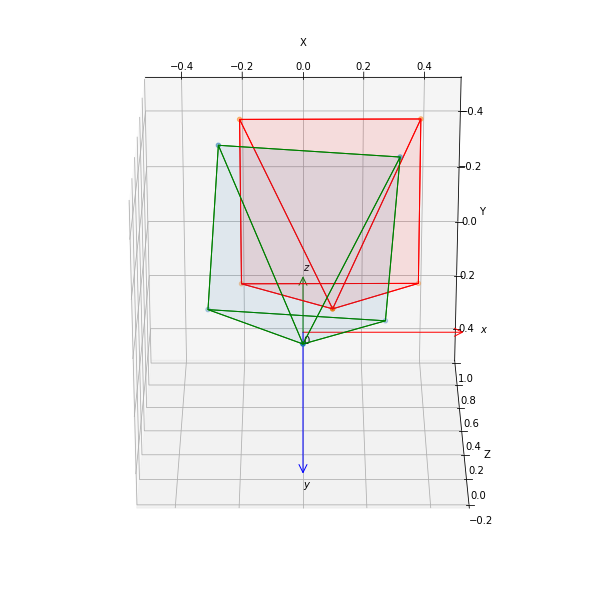

In [28]:
# Visualize camera pose  in 3D (example)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Draw Coordinate frame
plot_3d.plot_coordinate_system(ax, size = (0.5,0.5,0.5))

# Plot initial camera pose (green pyramid)
plot_3d.plot_camera(ax,R_init.numpy(),t_init.numpy(), edgecolor="g", facecolor=None, alph=0.05)

# Plot final camera pose (red pyramid)
plot_3d.plot_camera(ax,R.numpy(),t.numpy(), edgecolor="r", facecolor="r", alph=0.05)

# Adjust Angle of 3D plot view
ax.view_init(elev=-65, azim=-90)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(-0.2, 1)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# ToDo: Scatter the 3D points in this plot

# Show Plot
plt.show()

In [29]:
plt.imshow(img_list[0])

NameError: name 'img_list' is not defined

In [ ]:
new_proj_1[mask,:]
